In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_core.python.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
class InputToCx(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(InputToCx, self).__init__()
        self.output_dim = output_dim

    def call(self, inputs, **kwargs):
        real = tf.cos(inputs)
        imag = tf.sin(inputs)
        return tf.stack([real, imag], axis=1)

In [3]:
class CxMO(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxMO, self).__init__()
        self.output_dim = output_dim

    # input[0,:,:] = real
    # input[1,:,:] = image
    def build(self, input_dim):
        self.phi = self.add_variable("phi",
                                     shape=[int(input_dim[-2]),
                                            int(input_dim[-1])])

        super(CxMO, self).build(input_dim)

    def call(self, x):
        x_real = Lambda(lambda x: x[: ,0, :, :], output_shape=self.output_dim)(x)  # real
        x_imag = Lambda(lambda x: x[: ,1, :, :], output_shape=self.output_dim)(x)  # imag
        mo_real = tf.cos(self.phi)
        mo_imag = tf.sin(self.phi)

        real = tf.matmul(x_real, mo_real) - tf.matmul(x_imag, mo_imag)
        imag = tf.matmul(x_real, mo_imag) + tf.matmul(x_imag, mo_real)
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx

In [4]:
class FreeSpacePropagation(tf.keras.layers.Layer):
    def __init__(self, output_dim, k, z, input_pitch=1e-6, output_pitch=1e-6):
        super(FreeSpacePropagation, self).__init__()
        self.output_dim = output_dim
        self.input_pitch = input_pitch
        self.output_pitch = output_pitch
        self.z = z
        self.k = k

    def build(self, input_shape):

        x1 = np.arange(0, input_shape[-1], 1)
        y1 = np.arange(0, input_shape[-2], 1)
        xx1, yy1 = np.meshgrid(x1, y1)
        xx1 = xx1.reshape(-1, 1) - input_shape[-1]/2
        yy1 = yy1.reshape(-1, 1) - input_shape[-2]/2

        x2 = np.arange(0, self.output_dim[1], 1)
        y2 = np.arange(0, self.output_dim[0], 1)
        xx2, yy2 = np.meshgrid(x2, y2)
        xx2 = xx2.reshape(1, -1) - self.output_dim[1]/2
        yy2 = yy2.reshape(1, -1) - self.output_dim[0]/2

        dx = (self.output_pitch * xx2 - self.input_pitch * xx1)
        dy = (self.output_pitch * yy2 - self.input_pitch * yy1)
        r = np.sqrt(dx**2 + dy**2 + self.z**2)
        w = 1/(2*np.pi) * self.z / r * (1/r - 1j*self.k) * np.exp(1j * self.k * r)

        self.w_real = tf.Variable(initial_value=w.real.astype('float32'),
                                              trainable=False)
        self.w_imag = tf.Variable(initial_value=w.imag.astype('float32'),
                                              trainable=False)

        super(FreeSpacePropagation, self).build(input_shape)

    def call(self, x, **kwargs):
        x_real = Lambda(lambda x: x[:,0, :, :], output_shape=(self.output_dim,))(x)  # real
        x_imag = Lambda(lambda x: x[:,1, :, :], output_shape=(self.output_dim,))(x)  # imag
        x_real = tf.reshape(x_real, (-1, x.shape[-1]*x.shape[-2]))
        x_imag = tf.reshape(x_imag, (-1, x.shape[-1]*x.shape[-2]))
        real = tf.matmul(x_real, self.w_real) - tf.matmul(x_imag, self.w_imag)
        imag = tf.matmul(x_imag, self.w_real) + tf.matmul(x_real, self.w_imag)
        real = tf.reshape(real, (-1, self.output_dim[0], self.output_dim[1]))
        imag = tf.reshape(imag, (-1, self.output_dim[0], self.output_dim[1]))
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx


In [78]:
class CxD2NNMNISTDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super(CxD2NNMNISTDetector, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.input_dim = input_shape
        self.width = int(tf.floor(self.input_dim[2]/4.0))
        self.height = int(tf.floor(self.input_dim[1]/3.0))
        super(CxD2NNMNISTDetector, self).build(input_shape)

    def call(self, x, **kwargs):
        y0 = x[:, 0:self.height-1, 0:self.width-1]
        y1 = x[:, 0:self.height-1, self.width:self.width*2-1]
        y2 = x[:, 0:self.height-1, self.width*2:self.width*3-1]
        y3 = x[:, self.height:self.height*2-1, 0:self.width-1]
        y4 = x[:, self.height:self.height*2-1, self.width:self.width*2-1]
        y5 = x[:, self.height:self.height*2-1, self.width*2:self.width*3-1]
        y6 = x[:, self.height:self.height*2-1, self.width*3:self.width*4-1]
        y7 = x[:, self.height*2:self.height*3-1, 0:self.width-1]
        y8 = x[:, self.height*2:self.height*3-1, self.width:self.width*2-1]
        y9 = x[:, self.height*2:self.height*3-1, self.width*2:self.width*3-1]
        y0 = tf.reduce_sum(y0, axis=[1])
        y0 = tf.reduce_sum(y0, axis=[1], keepdims=True)
        y1 = tf.reduce_sum(y1, axis=[1])
        y1 = tf.reduce_sum(y1, axis=[1], keepdims=True)
        y2 = tf.reduce_sum(y2, axis=[1])
        y2 = tf.reduce_sum(y2, axis=[1], keepdims=True)
        y3 = tf.reduce_sum(y3, axis=[1])
        y3 = tf.reduce_sum(y3, axis=[1], keepdims=True)
        y4 = tf.reduce_sum(y4, axis=[1])
        y4 = tf.reduce_sum(y4, axis=[1], keepdims=True)
        y5 = tf.reduce_sum(y5, axis=[1])
        y5 = tf.reduce_sum(y5, axis=[1], keepdims=True)
        y6 = tf.reduce_sum(y6, axis=[1])
        y6 = tf.reduce_sum(y6, axis=[1], keepdims=True)
        y7 = tf.reduce_sum(y7, axis=[1])
        y7 = tf.reduce_sum(y7, axis=[1], keepdims=True)
        y8 = tf.reduce_sum(y8, axis=[1])
        y8 = tf.reduce_sum(y8, axis=[1], keepdims=True)
        y9 = tf.reduce_sum(y9, axis=[1])
        y9 = tf.reduce_sum(y9, axis=[1], keepdims=True)
        y = tf.keras.layers.concatenate([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9])

        if self.activation == 'softmax':
            y = tf.nn.softmax(y)
        return y

In [68]:
class CxD2NNIntensity(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization='min_max', **kwargs):
        super(CxD2NNIntensity, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.normalization = normalization

    def call(self, x, **kwargs):
        real = Lambda(lambda x: x[:, 0, :, :])(x)
        image = Lambda(lambda x: x[:, 1, :, :])(x)
        intensity = tf.sqrt(real ** 2 + image ** 2)
        if self.normalization == 'min_max':
            max = tf.reduce_max(intensity)
            min = tf.reduce_min(intensity)
            intensity = (intensity - min)/(max - min)
        return intensity

In [6]:
class MOD2NN(tf.keras.Model):
    def __init__(self):
        super(MOD2NN, self).__init__()
        self.l = 633e-9
        self.k = 2 * np.pi / self.l
        self.d = 1e-6
        self.mo1 = CxMO((28, 28))
        self.propag1 = FreeSpacePropagation((28, 28), self.d, 2e-3, self.k)
        self.mo2 = CxMO((28, 28))
        self.prooag2 = FreeSpacePropagation((1, 10), self.d*2, 1e-9, self.k)

    def call(self, x):
        x = self.mo1(inputs)
        x = self.propag1(x)
        x = self.mo2(x)
        x = self.prooag2(x)
        x = tf.nn.softmax(x[0,:,:])

        return x

In [73]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)

In [89]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

In [9]:
l = 633e-9
k = 2 * np.pi / l
d = 1e-6

(100, 100)

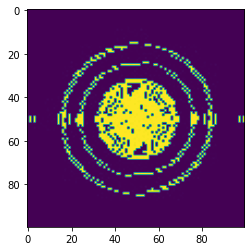

In [10]:
img = cv2.imread('./data/fingerprint.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
img.shape

In [91]:
inputs = keras.Input((28,28))
x = InputToCx((28, 28))(inputs)
x = CxMO((28, 28))(x)
x = FreeSpacePropagation((28, 28), k, 2e-4, output_pitch=1e-6)(x)
x = CxD2NNIntensity((28, 28), normalization='min_max')(x)
x = CxD2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=5, epochs=10)

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
input_to_cx_41 (InputToCx)   (None, 2, 28, 28)         0         
_________________________________________________________________
cx_mo_41 (CxMO)              (None, 2, 28, 28)         784       
_________________________________________________________________
free_space_propagation_41 (F (None, 2, 28, 28)         1229312   
_________________________________________________________________
cx_d2nn_intensity_31 (CxD2NN (None, 28, 28)            0         
_________________________________________________________________
cx_d2nnmnist_detector_36 (Cx (None, 10)                0         
Total params: 1,230,096
Trainable params: 784
Non-trainable params: 1,229,312
______________________________________________

In [71]:
out = model.predict(np.array([x_train[0,:,:]]))
out

array([[10.52823 , 18.701698, 18.238728, 12.326464, 21.341318, 20.850506,
        14.157367, 15.142569, 25.804714, 25.074333]], dtype=float32)